Loading data…
10000 environments loaded
Total rows with NaN values: 0 out of 10
Done in 18.5s (1.85s/env)
Results saved to ../results/mae_10_envs.pkl
Plot saved to ../results/mae_10_envs.png


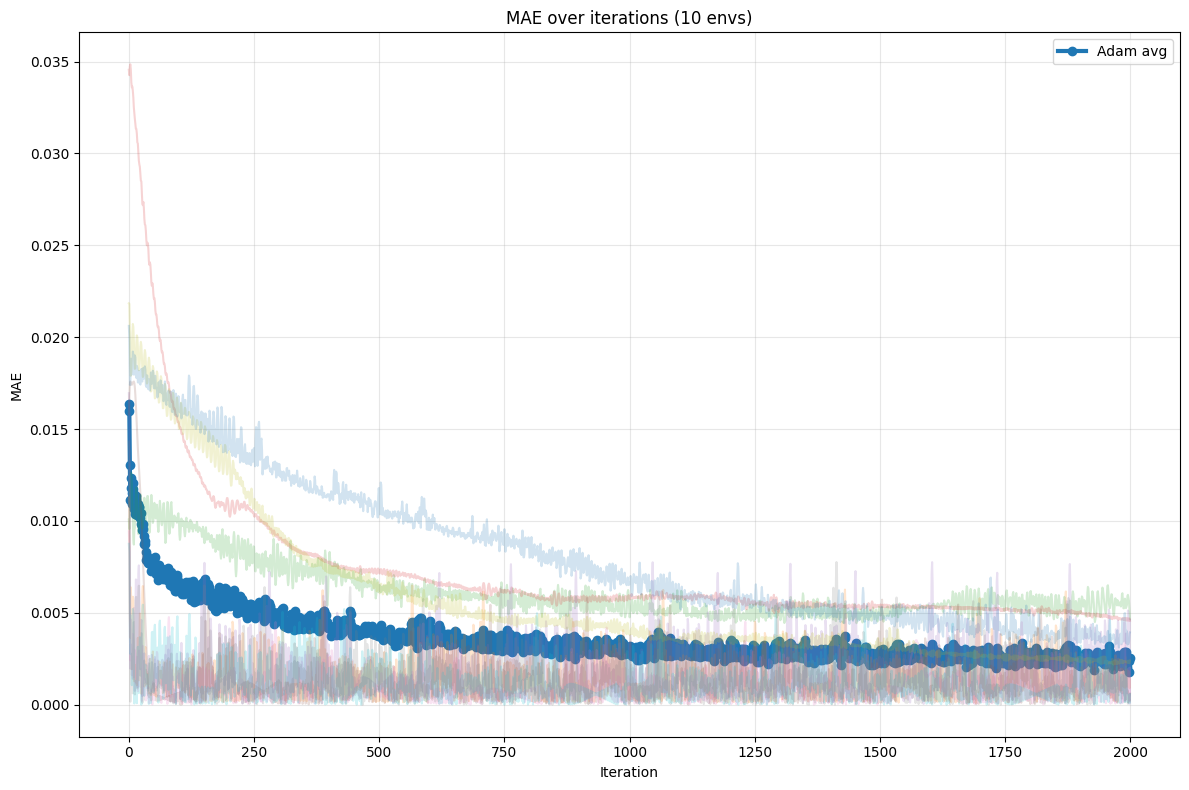

In [3]:
"""
Bispectrum Inversion for Molecular Environments - Optimized for Apple M2 Pro
"""
import os
import time
import pickle

import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from functools import partial
import math

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from spectra import sum_of_diracs, bispectrum

#------------------------------------------------------------------------------
# JAX & Hardware Configuration
#------------------------------------------------------------------------------

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'gpu')
jax.config.update('jax_default_matmul_precision', 'high')
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.85'

#------------------------------------------------------------------------------
# Constants
#------------------------------------------------------------------------------

LMAX = 5
MAX_ENV_SIZE = 5

#------------------------------------------------------------------------------
# Helpers
#------------------------------------------------------------------------------

def determine_optimal_batch_size() -> int:
    """Pick a default batch size: 8 on M1/M2 silicon, else 5."""
    try:
        import platform
        return 8 if platform.processor() == 'arm' else 5
    except:
        return 5

@partial(jax.jit, static_argnames=('max_size',))
def pad_environment(env, max_size=MAX_ENV_SIZE):
    """
    Take an (N×3) array (N may be <, =, or > max_size),
    pad it with zeros so it has at least (max_size) rows,
    then slice to exactly (max_size×3).
    """
    env = jnp.array(env, dtype=jnp.float64)             # (N,3)
    # Pad below with max_size zeros → shape = (N+max_size, 3)
    padded = jnp.pad(env, ((0, max_size), (0, 0)))
    # Then take the first max_size rows: shape = (max_size, 3)
    return padded[:max_size]

@jax.jit
def compute_bispectrum_for(env):
    """Compute bispectrum for an (M×3) array, zeros allowed."""
    return bispectrum(sum_of_diracs(env, LMAX))

@partial(jax.jit, static_argnums=(2,))
def invert_with_adam(true_bs, init_pts, num_iters=2000):
    """Adam-based inversion."""
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = bispectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def step(carry, _):
        pts, st = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        return (optax.apply_updates(pts, updates), st), None
    (final_pts, _), _ = jax.lax.scan(step, (init_pts, state), None, length=num_iters)
    return final_pts

@partial(jax.jit, static_argnums=(2,))
def invert_with_adam_history(true_bs, init_pts, num_iters=2000):
    """Adam-based inversion (returns history)."""
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = bispectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def scan_step(carry, i):
        pts, st, hist = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        pts = optax.apply_updates(pts, updates)
        hist = hist.at[i].set(pts)
        return (pts, st, hist), None

    hist0 = jnp.broadcast_to(init_pts, (num_iters, *init_pts.shape))
    ( _, _, history ), _ = jax.lax.scan(scan_step, (init_pts, state, hist0), jnp.arange(num_iters))
    return history                                                   # (S,20,3)

def stack_points(points: np.ndarray) -> jnp.ndarray:
    """
    Cluster points by alignment (cosine > 0.866), sum and threshold
    with half the max norm. Returns (K×3) JAX array or empty.
    """
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    valid = norms[:,0] > 0
    pts = points.copy()
    pts[valid] /= norms[valid]
    D = pts @ pts.T
    used = np.ones(len(points),bool)
    clusters = []
    while used.any():
        i = np.argmax(used)
        aligned = (D[i] > 0.866) & used
        if not aligned.any(): break
        clusters.append(points[aligned].sum(0))
        used[aligned] = False
    if not clusters:
        return jnp.zeros((0,3), jnp.float64)
    C = np.stack(clusters)
    norms = np.linalg.norm(C, axis=1)
    thresh = 0.5 * norms.max()
    C = C[norms >= thresh]
    return jnp.array(C, jnp.float64)

def radius_mae_fast(a1: np.ndarray, a2: np.ndarray) -> float:
    """MAE of sorted non-zero radii; returns 0.0 if both empty."""
    r1 = np.linalg.norm(a1, axis=1); r2 = np.linalg.norm(a2, axis=1)
    r1, r2 = np.sort(r1[r1>1e-10]), np.sort(r2[r2>1e-10])
    if len(r1)==0 and len(r2)==0: return 0.0
    if len(r1)!=len(r2): return np.nan
    return float(np.mean(np.abs(r1 - r2)))

#------------------------------------------------------------------------------
# Main Pipeline
#------------------------------------------------------------------------------

def process_environments(envs, num_to_use=20, batch_size=None, scale=1, num_starts=5):
    if num_to_use and num_to_use < len(envs):
        envs = envs[:num_to_use]
    batch_size = batch_size or determine_optimal_batch_size()
    start = time.time()

    # Precompute padded geometries & bispectra
    padded = [scale * pad_environment(e) for e in envs]   # list of (MAX_ENV_SIZE,3)
    targets = [compute_bispectrum_for(e) for e in padded]

    all_maes = []
    master_rng = jax.random.PRNGKey(0)
    num_iters = 2000

    for idx, (true_bs, geom) in enumerate(zip(targets, padded)):
        best_loss = np.inf
        best_hist = None
        geom_np = np.array(geom)

        for _ in range(num_starts):
            # 1) split RNG, sample a fresh init
            master_rng, subkey = jax.random.split(master_rng)
            init_pts = jax.random.normal(subkey, (20,3), jnp.float64)

            # 2) first inversion
            final_pts = invert_with_adam(true_bs, init_pts)       # (20,3)

            # 3) cluster the result
            stacked = stack_points(np.array(final_pts))  # jnp (K,3) or zeros

            # 4) second inversion (history) on clustered points
            if stacked.shape[0] > 0:
                hist = invert_with_adam_history(true_bs, stacked, num_iters=num_iters)  # (num_iters, K,3)
                hist_np = np.array(hist)
                # compute MAE of only the *last* iterate
                final_pred = hist_np[-1]
                loss = np.mean(np.abs(compute_bispectrum_for(final_pred) - true_bs))
            else:
                loss = np.inf

            # 5) keep if best
            if loss < best_loss:
                best_loss = loss
                best_hist = hist_np  # may be None if stacked was empty

        # after trying all starts, record the best‐run MAE‐curve
        if best_hist is not None:
            maes = [radius_mae_fast(h, geom_np) / scale for h in best_hist]
        else:
            maes = [np.nan] * num_iters

        all_maes.append(maes)

        if idx % batch_size == 0:
            jax.clear_caches()

    elapsed = time.time() - start
    all_maes = np.array(all_maes)  # (num_envs, num_iters)
    nan_counts = np.isnan(all_maes).any(axis=1).sum()
    print(f"Total rows with NaN values: {nan_counts} out of {len(all_maes)}")
    avg = np.nanmean(all_maes, axis=0)
    print(f"Done in {elapsed:.1f}s ({elapsed/len(envs):.2f}s/env)")

    return {
        "all_mae_values": all_maes,
        "avg_mae": avg,
        "processing_time": elapsed,
        "num_envs": len(envs)
    }

def save_and_plot_results(res, out_dir="../results"):
    os.makedirs(out_dir, exist_ok=True)
    n = res["num_envs"]
    fname = f"{out_dir}/mae_{n}_envs.pkl"
    with open(fname, "wb") as f:
        pickle.dump(res, f)
    print(f"Results saved to {fname}")

    plt.figure(figsize=(12,8))
    iters = np.arange(len(res["avg_mae"]))
    plt.plot(iters, res["avg_mae"], marker='o', linewidth=3, label="Adam avg")
    for row in res["all_mae_values"]:
        plt.plot(iters, row, alpha=0.2)
    # plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("MAE")
    plt.title(f"MAE over iterations ({n} envs)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    png = f"{out_dir}/mae_{n}_envs.png"
    plt.savefig(png, dpi=300)
    print(f"Plot saved to {png}")
    return plt

def main():
    print("Loading data…")
    with open('../data/qm9_local_envs_10000.pkl','rb') as f:
        envs = pickle.load(f)
    print(f"{len(envs)} environments loaded")

    # Warm up JIT
    _ = compute_bispectrum_for(jnp.zeros((3,3)))

    results = process_environments(envs, num_to_use=10, num_starts=1)
    plt = save_and_plot_results(results)
    plt.show()

if __name__ == "__main__":
    main()

Loaded results from ../results/mae_200_envs.pkl


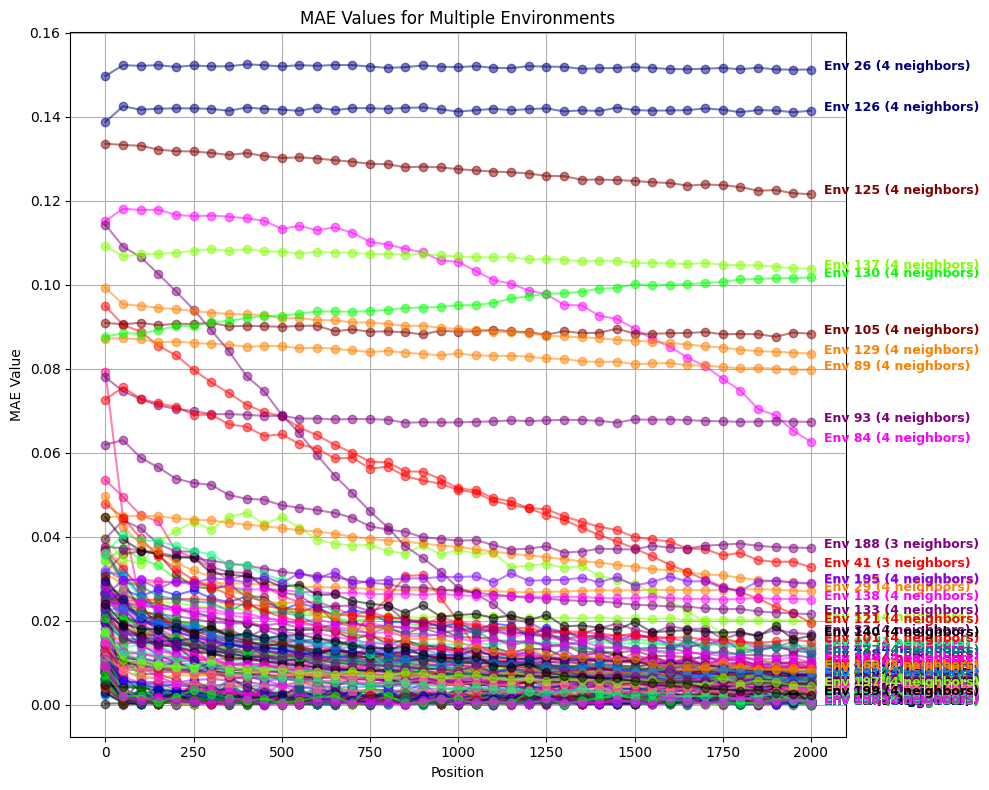

In [47]:
num_envs = 200

with open('../data/qm9_local_envs_10000.pkl','rb') as f:
    envs = pickle.load(f)

# Load and display saved results
output_file = f"../results/mae_{num_envs}_envs.pkl"

try:
    with open(output_file, "rb") as f:
        results = pickle.load(f)
    print(f"Loaded results from {output_file}")
except FileNotFoundError:
    print(f"Results file not found: {output_file}")
except Exception as e:
    print(f"Error loading results: {str(e)}")

# Plot all MAE values on the same plot
fig, ax = plt.subplots(figsize=(10, 8))

# Check if results contain the necessary data
if 'all_mae_values' not in results:
    print("Error: 'all_mae_values' not found in results dictionary")
else:
    # Use a colormap with more distinct colors
    import matplotlib.colors as mcolors
    # Combine multiple colormaps to get more distinct colors
    # Use a set of highly distinguishable colors that are clearly visible on white background
    colors = ['#000000', '#FF0000', '#0000FF', '#008000', '#FF00FF', '#800000', 
              '#000080', '#008080', '#800080', '#FF8000', '#00FF00', '#0080FF',
              '#FF0080', '#800080', '#FF8080', '#8000FF', '#00FF80', '#80FF00',
              '#FF00FF', '#000000']  # High contrast colors, starting with black, red, blue, green
    
    # Plot each environment's MAE values with different colors
    # Only plot every 50 iterations to reduce noise, but always include the last point
    step = 50
    for i in range(len(results['all_mae_values'])):
        mae_values = results['all_mae_values'][i]
        
        # Get indices for every step-th point
        indices = list(range(0, len(mae_values), step))
        
        # Make sure the last point is included
        if (len(mae_values) - 1) not in indices:
            indices.append(len(mae_values) - 1)
        
        # Get x and y values for plotting
        x_values = indices
        y_values = [mae_values[j] for j in indices]
        
        line = ax.plot(x_values, y_values, marker='o', linestyle='-', 
                alpha=0.5, color=colors[i % len(colors)])
        
        # Annotate curves with final MAE > 0.01
        if mae_values[-1] > 0:
            # Get number of neighbors for this environment
            num_neighbors = len(envs[i])
            
            # Add annotation at the end of the curve
            ax.annotate(f'Env {i} ({num_neighbors} neighbors)', 
                        xy=(len(mae_values)-1, mae_values[-1]),
                        xytext=(10, 0),
                        textcoords='offset points',
                        fontsize=9,
                        fontweight='bold',
                        color=colors[i % len(colors)])
    
    ax.set_title('MAE Values for Multiple Environments')
    ax.set_xlabel('Position')
    ax.set_ylabel('MAE Value')
    # ax.set_ylim(0, 0.02)
    ax.grid(True)
    
    # Set integer x-axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()


In [48]:
# Compute average MAE at the last iteration for environments with MAE < 0.03
# last_iteration_maes = [mae_values[-1] for mae_values in results['all_mae_values']]
# good_maes = [mae for mae in last_iteration_maes if mae < 0.03]
# average_last_mae = np.mean(good_maes) if good_maes else 0
# print(f"Average MAE at the last iteration (for MAE < 0.03): {average_last_mae:.6f}")
# print(f"Number of environments with MAE < 0.03: {len(good_maes)} out of {len(last_iteration_maes)}")

last_iteration_maes = [mae_values[-1] for mae_values in results['all_mae_values']]
print(f"Average MAE at the last iteration: {np.nanmean(last_iteration_maes):.6f}")

# 1 start = 0.005057, 0.54 s/env
# 5 start = 0.004040, 1.25 s/env
# 10 start = 0.003247, 1.33 s/env
# 20 start = 0.003451, 1.50 s/env

# 10 start, 0.004805
# 10 start with l-bfgs, 

Average MAE at the last iteration: 0.009221
